In [ ]:
!pip install TensorFlow
!pip install Keras
!pip install pillow
!pip install NumPy
!pip install tqdm
!pip install jupyterlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 19.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 28.7 MB/s 
     |████████████████████████████████| 342 kB 64.6 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 428 kB 58.6 MB/s 
     |████████████████████████████████| 561 kB 52.0 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
   

In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


0it [00:00, ?it/s]

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = ' 230_Project'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/230_Project


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 10:05:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

In [4]:
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
   table = str.maketrans('','', string.punctuation)
   for img, caps in captions.items():
     for i, img_caption in enumerate(caps):
       img_caption.replace("-"," ")
       descp = img_caption.split()
       #uppercase to lowercase
       descp = [wrd.lower() for wrd in descp]
       #remove punctuation from each token
       descp = [wrd.translate(table) for wrd in descp]
       #remove hanging 's and a
       descp = [wrd for wrd in descp if (len(wrd) > 1)]
       #remove words containing numbers with them
       descp = [wrd for wrd in descp if (wrd.isalpha())]
       #converting back to string
       img_caption = ' '.join(descp)
       captions[img][i] = img_caption
     return captions


def txt_vocab(descriptions):
  # To build vocab of all unique words
   vocab = set()
   for key in descriptions.keys():
       [vocab.update(d.split()) for d in descriptions[key]]
   return vocab


#To save all descriptions in one file
def save_descriptions(descriptions, filename):
   lines = list()
   for key, desc_list in descriptions.items():
     for desc in desc_list:
           lines.append(key + '\@' + desc )
   data = "\&".join(lines)
   file = open(filename,"w")
   file.write(data)
   file.close()

In [10]:
import pandas as pd
import numpy as np
import os
import ast
import cv2
from collections import defaultdict


def getCaptions():
    # df = pd.read_csv("drive/MyDrive/junior year/Copy of artemis_dataset_release_v0.csv")
    df = pd.read_csv("./artemis_dataset_release_v0.csv")
    captions = defaultdict(list)
    for index, row in df.iterrows():
        if len(captions[row[1]]) < 5:
            caption = row[3]
            # getting first sentence of every annotation
            ind = caption.find('.')
            captions[row[1]].append(caption[:ind])
    print("Done adding to dict!")
    return captions

In [6]:
# change to our dataset paths
dataset_text = "./captions.txt"
dataset_images = "./images"

In [11]:
#to prepare our text data
#map captions into descriptions dictionary 
descriptions = getCaptions()
print("Length of descriptions =", len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
for key, value in clean_descriptions.items():
  print(key)
  print(value)
  break
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
# saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

Done adding to dict!
Length of descriptions = 80031
vincent-van-gogh_portrait-of-madame-ginoux-l-arlesienne-1890
['she seems very happy in the picture and you want to know what what is behind the smile', 'this woman has really knotty hands which makes her look like she has arthritis', 'when looking at this woman am filled with curiosity about what she is thinking about with her elbow on the table and very emotionless face', 'woman looking at ease peaceful and satisfied amongst her books makes me feel content', 'she looks like lady from that past that might have been teacher books']
Length of vocabulary =  79943


In [ ]:
#descriptions['claudio-tozzi_papag-lia']
descriptions['constantin-artachino_white-headscarf']

['This image really looks amazing with how realistic it looks with so simple of colors. I love the slight red that is brought about close to the ear since it allows a bit of color among everything else',
 'This painting is well done and very natural looking. I am not weirded out by the facial arrangement like so many other painting like it.',
 'The look of peace on the face is nice to me',
 'The young girl is wearing hijab and looks lost in thought as she reflects on her life',
 'This painting makes me feel content, looking at the steady face here.']

In [ ]:
def extract_features(directory):
  model = Xception( include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3))
  features = {}
  for img in tqdm(os.listdir(directory)):
    filename = directory + "/" + img
    image = Image.open(filename)
    #image = image.resize((224, 224))
    image = np.expand_dims(image, axis=0)
    #image = preprocess_input(image)
    image = image / 127.5
    image = image - 1.0

    feature = model.predict(image)
    features[img] = feature
  return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

83697664/83683744 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/14668 [00:00<?, ?it/s]

In [22]:
#load the data 
def load_photos(filename):
  file = load_fp(filename)
  photos = file.split("\n")[:-1]
  return photos

def load_clean_descriptions(filename, photos): 
  #loading clean_descriptions
  file = load_fp(filename)
  captions = file.split('\&')
  descriptions = defaultdict(list)
  for img in photos:
    name = img[:-4]
    captions = clean_descriptions[name]
    for caption in captions:
        desc = '<start> ' + caption + ' <end>'
        descriptions[name].append(desc)
  '''     
  for img, captions in clean_descriptions.items():
    imgName = img + ".jpg"
    if imgName in photos:
      for caption in captions:
        desc = '<start> ' + caption + ' <end>'
        descriptions[img].append(desc)'''
  return descriptions

def load_features(photos):
  #loading all features
  all_features = load(open("features.p","rb"))
  #selecting only needed features
  features = {k:all_features[k] for k in photos}
  return features


In [41]:
import random

filename = dataset_text
all_imgs = list(load(open("features.p","rb")).keys())
selection = random.sample(range(0, 14600), 14500)
# select test set of 200
test_idx = selection[:200]
# select random training set of 14300 images 
train_idx = selection[200:]
train_imgs = [all_imgs[i] for i in train_idx]
test_imgs = [all_imgs[i] for i in test_idx]
train2_idx = selection[:10]
train2_imgs = [all_imgs[i] for i in train2_idx]

In [42]:
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train2_descriptions = load_clean_descriptions("descriptions.txt", train2_imgs)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
train_features = load_features(train_imgs)
train2_features = load_features(train2_imgs)
test_features = load_features(test_imgs)
print(len(train_descriptions))
print(len(train2_descriptions))
print(len(test_descriptions))

14136
10
199


In [25]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  print(len(desc_list))
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
print(len(train_descriptions))
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

70705
14141
21457


In [56]:
#calculate maximum length of descriptions
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

In [57]:
max_length = max_length(clean_descriptions)
max_length

94

In [28]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      #retrieve photo features
      key = key + ".jpg"
      feature = features[key][0]
      input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
      yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = list(), list(), list()
  # walk through each description for the image
  for desc in desc_list:
  # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple x, y pairs
    for i in range(1, len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      # store
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

In [29]:
#You can check the shape of the input and output for your model
all_features = load(open("features.p","rb"))
[a, b], c = next(data_generator(train_descriptions, all_features, tokenizer, max_length))
a.shape, b.shape, c.shape

((85, 2048), (85, 94), (85, 21457))

In [30]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model squeezed from 2048 to 256 nodes
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)

  # LSTM sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)

  # Merging both models
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  # summarize model
  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)

  return model

Dataset:  14300
Descriptions: train= 14136
Photos: train= 14300
Vocabulary Size: 21457
Description Length:  94
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 94)]         0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 94, 256)      5492992     ['input_53[0][0]']               
                                                                                                  
 dropout_16 (Dropout)           (None, 2048)         0           ['input_52[0][0

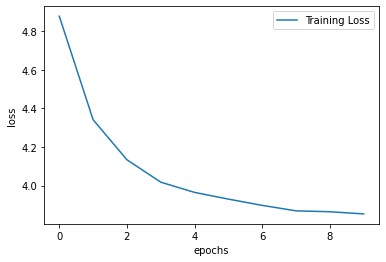

In [117]:
import matplotlib.pyplot as plt

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
steps = 10000

# 6 epochs is best - lowest loss

generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
training = model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
plt.plot(training.history["loss"], label="Training Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
model.save("models/model_4" + ".h5")

Dataset:  13000
Descriptions: train= 12847
Photos: train= 13000
Vocabulary Size: 19722
Description Length:  197
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 197)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 197, 256)     5048832     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0

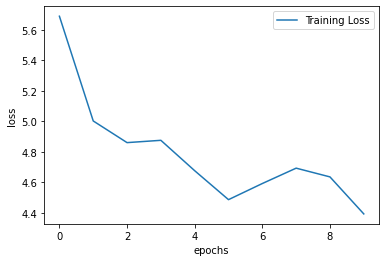

In [ ]:
import matplotlib.pyplot as plt

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 2
steps = 1000 #len(train_descriptions)
# making a directory models to save our models
# os.mkdir("models")

# 6 epochs is best - lowest loss

generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
training = model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
plt.plot(training.history["loss"], label="Training Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
model.save("models/model_1" + ".h5")

In [ ]:
# 2000, 5000, 7000, 10000 steps
# 5 epochs, 10

nn
start the colors are very not and the colors are very calming end


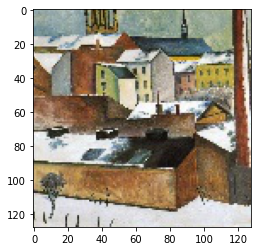

In [132]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_features(filename, model):
  try:
            image = Image.open(filename)
  except:
            print("ERROR: Can't open image! Ensure that image path and extension is correct")
            return
  image = image.resize((299,299))
  image = np.array(image)
  # for 4 channels images, we need to convert them into 3 channels
  if image.shape[2] == 4:
        image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image / 127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
          sequence = tokenizer.texts_to_sequences([in_text])[0]
          sequence = pad_sequences([sequence], maxlen=max_length)
          pred = model.predict([photo,sequence], verbose=0)
          pred = np.argmax(pred)
          word = word_for_id(pred, tokenizer)
          if word is None:
                    break
          in_text += ' ' + word
          if word == 'end':
                    break
    return in_text

max_length = 94
tokenizer = load(open("tokenizer.p","rb"))
xception_model = Xception(include_top=False, pooling="avg")
img = "images/" + test_imgs[89]
photo = extract_features(img, xception_model)
img = Image.open(img)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

In [112]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

In [113]:
def compute_bleu(imgs):
  xception_model = Xception(include_top=False, pooling="avg")
  test_img_scores = defaultdict(float)
  for i, img in enumerate(imgs):
    imgName = "images/" + img
    photo = extract_features(imgName, xception_model)
    #img = Image.open(img)
    description = generate_desc(model, tokenizer, photo, max_length)
    caption = ' '.join(description.split()[1 : -1])
    bleu_score = sentence_bleu([true_caption.split()[1 : -1] for true_caption in test_descriptions[img[:-4]]], caption.split(), smoothing_function=smoothie)
    test_img_scores[img] = bleu_score
  return test_img_scores


In [133]:
compute_bleu(test_imgs[:20])

defaultdict(float,
            {'adolphe-joseph-thomas-monticelli_gallant-party.jpg': 0.2541381286755765,
             'agnes-martin_the-islands-1979.jpg': 0.2332130329059486,
             'albert-bierstadt_elk.jpg': 0.21627972701344117,
             'albrecht-durer_studies-of-a-calvary.jpg': 0.25540778661907937,
             'alfred-sisley_near-moret-1891.jpg': 0.2307869877265558,
             'alvaro-lapa_unknown-title-7.jpg': 0.2901992735031966,
             'amedeo-modigliani_seated-boy-with-cap-1918.jpg': 0.24324605660109083,
             'anthony-van-dyck_deposition-1634.jpg': 0.21627972701344117,
             'arkhip-kuindzhi_crescent-moon-at-sunset.jpg': 0.20454473702045944,
             'bartolome-esteban-murillo_st-john-the-baptist-as-a-child.jpg': 0.21627972701344117,
             'bartolome-esteban-murillo_the-immaculate-conception-oil-on-canvas.jpg': 0.20454473702045944,
             'basuki-abdullah_nudtiy.jpg': 0.25540778661907937,
             'boris-kustodiev_portrait-